# Chapter 7. n-step Bootstrapping

- unify the Monte Carlo (MC) and the one-step temporal-difference (TD) methods
> _the benefit of n-step methods is that they free you from the tyranny of the time step_

## 7.1 n-step TD Prediction

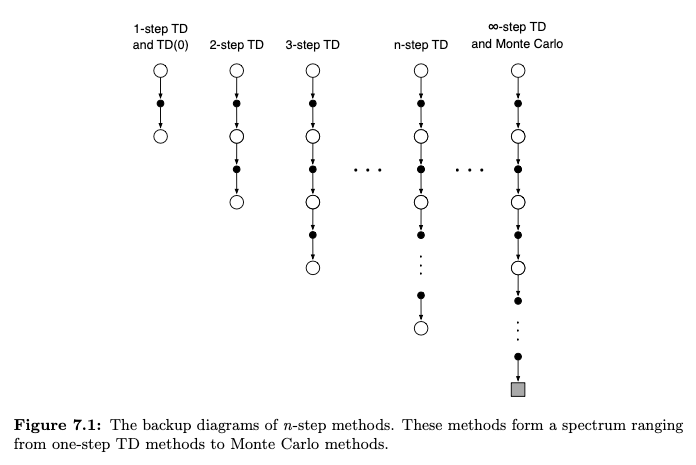

<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/v4.0.0-beta.7/" "latest.js?config=default'></script>

More formally, consider the update of the estimated value of state $S_t$ as a result of the state–reward sequence  (omitting the actions): $$S_t, R_{t+1}, S_{t+1}, R_{t+2}, . . . , R_T , S_T$$


### The target of the update.
- In **Monte Carlo updates** the estimate of $v_\pi(S_t)$ is updated in the direction of the complete return:
$$G_t \doteq R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \dots + \gamma^{T - t - 1} R_T , $$
  - where T is the last time step of the episode.

- Target in **one-step updates** is _one-step return_:
$$ G_{t:t+1} \doteq R_{t+1} + \gamma V_t(S_{t+1}), $$
where $V_t : \mathcal S \rightarrow \mathbb R$ here is the estimate at time t of $v_\pi$ .

  - $G_{t:t+1}$ is the truncated return for time t using rewards up until time t+1, with the discounted estimate $\gamma V_t(S_{t+1})$ taking the place of the other terms $\gamma R_{t+2} + \gamma^2 R_{t+3} + \dots + \gamma^{T - t - 1} R_T$ of the full return, as discussed in the previous chapter.

-  Target in **two-step update** is _two-step return_:
$$G_{t:t+2} \doteq R_{t+1} + \gamma R_{t+2} + \gamma^2 V_{t+1}(S_{t+2}),$$

  - where now $\gamma^2 V_{t+1}(S_{t+2})$ corrects for the absence of the terms $\gamma^2 R_{t+3} + \gamma^3 R_{t+4} + \dots + \gamma^{T-t-1} R_T$.

- Similarly, of arbitrary **n-step update** is the _n-step return_:
$$G_{t:t+n} \doteq R_{t+1} + \gamma R_{t+2} + \dots + \gamma^{n-1}R_{t+n} + \gamma^n V_{t+n-1}(S_{t+n}), \qquad (7.1)$$
  - for all n, t such that $n \geq 1$ and $0 \leq t < T-n$.
  - All n-step returns can be considered **approximations to the full return**, truncated after n steps and then **corrected for the remaining missing terms** by $V_{t+n-1}(S_{t+n})$.
  - If $t + n \geq T$ (if the n-step return extends to or beyond termination), then all the missing terms are taken as zero, and the n-step return defined to be equal to the ordinary full return
$(G_{t:t+n} \doteq G_t$ if $t + n \geq T )$.

Note
- n-step returns for n > 1 involve future rewards and states that are not available at the time of transition from t to t + 1.
- **No real algorithm can use the n-step return until after it has seen $R_{t+n}$ and computed $V_{t+n-1}$**.
- The first time these are available is t + n.
- Thus (**n-step TD** algorithm):
$$V_{t+n}(S_t) \doteq V_{t+n-1}(S_t) + \alpha [ G_{t:t+n} - V_{t+n-1}(S_t)],
\quad 0 \leq t < T,\qquad (7.2)$$

while the values of all other states remain unchanged: $V_{t+n}(s) = V_{t+n-1}(s)$, for all $s \not= S_t$.


Note: 
- no changes at all are made during the first n-1 steps of each episode.
- To make up for that, an equal number of additional updates are made at the end of the episode, after termination and before starting the next episode.

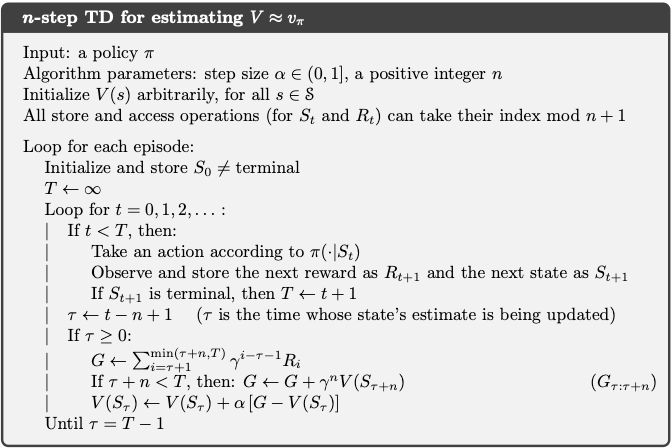


### Exercise 7.1
In Chapter 6 we noted that the Monte Carlo error can be written as the
sum of TD errors (6.6) if the value estimates don't change from step to step. Show that the n-step error used in (7.2) can also be written as a sum of TD errors (again if the value estimates don't change) generalizing the earlier result.


#### Proof

- Let the (constant) value estimate be
$$V(s) \doteq V_1(s) = \dots = V_{t+n}(s)$$
- Recall the (1-step) TD-error (6.5):
$$ \delta_t \doteq R_{t+1} + \gamma V(S_{t+1}) - V(S_t)  $$
- Let the n-step TD-error at time step t be
$$ \delta_t^{(n)} \doteq G_{t:t+n} - V(S_t)  $$

- Then:

\begin{align}
\delta_t^{(n)}
  &= (R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \ldots + \gamma^{n-1} R_{t+n} + \gamma^n V(S_{t+n})) - V(S_t) & (3.9) \\
  &= \sum_{i=0}^{n-1} \left[  \gamma^i R_{t+i+1} \right] + \gamma^n V(S_{t+n}) - V(S_t) \\
  &= \sum_{i=0}^{n-1} \left[  \gamma^i R_{t+i+1} + \gamma^{i+1} V(S_{t+i+1}) - \gamma^{i} V(S_{t+i}) \right]  & \text{(telescoping series)} \\
  &= \sum_{i=0}^{n-1} \gamma^i \delta_{t+i} &\square\\  
\end{align}

### Exercise 7.2 (programming)
With an n-step method, the value estimates do change from step to step, so an algorithm that used the sum of TD errors (see previous exercise) in place of the error in (7.2) would actually be a slightly different algorithm. Would it be a better algorithm or a worse one? Devise and program a small experiment to answer this question empirically.

##### Answer
- Usually it would be a worse algorithm, since it would update the value estimation only at the end of an episode

In [3]:
from IPython.display import display

from gymnasium.envs.registration import register
from gymnasium import make

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

register(id="RL/RandomWalk-v0", entry_point="envs.random_walk:RandomWalkEnv")

/Users/beerol/git/privat/readings/.venv/lib/python3.12/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment RL/RandomWalk-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


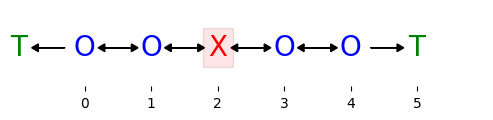

In [4]:
# Create the environment
env = make('RL/RandomWalk-v0', num_non_terminal_states=5, start_state=2)

env.reset()
env.render()

In [5]:
def standard_n_step_td(policy, env, n, alpha, gamma, num_episodes):
    # Initialise V arbitrary, here with zeroes.
    V = np.zeros(env.observation_space.n)

    for episode in range(num_episodes):
        state, _ = env.reset()
        states = [state]
        rewards = [0]
        terminateds = [False]

        T = float('inf')
        t = 0
        while True:
            if t < T:
                action = policy(state)
                next_state, reward, terminated = env.step(action)[:3]
                states.append(next_state)
                rewards.append(reward)

                if terminated:
                    T = t + 1

            tau = t - n + 1
            if tau >= 0:
                G = sum(
                    gamma ** (i - tau - 1) * rewards[i]
                    for i in range(tau + 1, min(tau + n, T) + 1)
                )
                if tau + n < T:
                    G += gamma ** n * V[states[tau + n]]

                td_n_steps = G - V[states[tau]]
                
                V[states[tau]] += alpha * (td_n_steps)

                # Todo: (before break-command or here?)
                td_0_sum = ...

            if tau == T - 1:
                break

            state = next_state
            t += 1
        
    
    return V

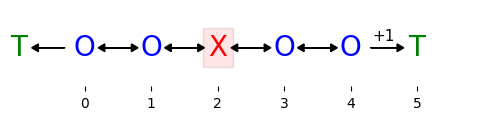

,true_values,1-step,2-step,3-step,4-step
0,16.67%,6.74%,4.31%,13.16%,11.92%
1,33.33%,15.53%,20.84%,31.63%,25.44%
2,50.00%,35.41%,34.02%,48.28%,48.82%
3,66.67%,65.43%,52.60%,63.67%,83.16%
4,83.33%,87.49%,79.65%,79.09%,97.88%


true_values    0.000000
1-step         0.254409
2-step         0.278467
3-step         0.067200
4-step         0.238711
Name: RMSE, dtype: float64

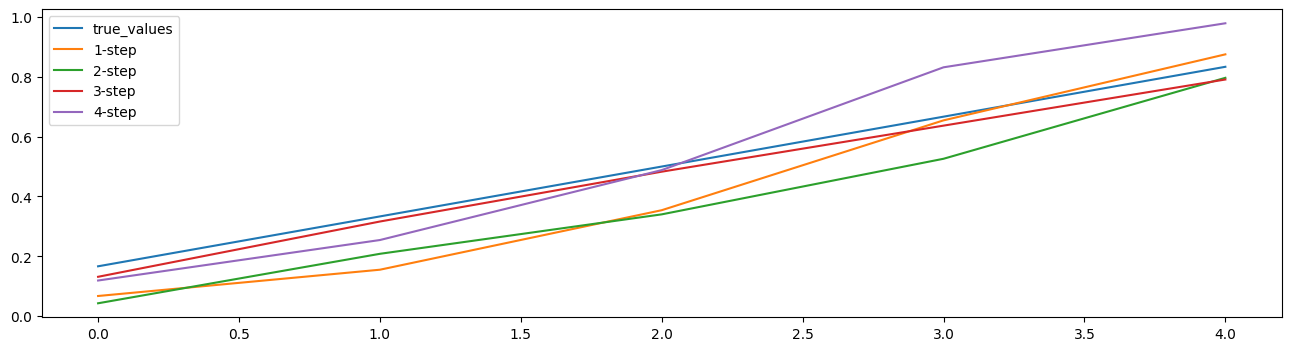

In [6]:
# Parameters
n = 3
alpha = 0.1
gamma = 1.0
num_episodes = 100
num_non_terminal_states=5
start_state = num_non_terminal_states // 2
rewards = {(num_non_terminal_states - 1, num_non_terminal_states): 1}

# Define a random policy for testing
def random_policy(state):
    return int(np.random.choice([0, 1]))

env = make('RL/RandomWalk-v0', num_non_terminal_states=num_non_terminal_states, start_state=start_state, rewards=rewards)
env.reset()
env.render()

value_functions = { 'true_values': np.array([i / 6 for i in range(1, 6) ]) }

for n in range(1, num_non_terminal_states):    
    value_function = standard_n_step_td(random_policy, env, n, alpha, gamma, num_episodes)
    value_functions[f"{n}-step"] = value_function

df = pd.DataFrame(value_functions)
rmse = pd.Series(
    data={
        k : sum((v - value_functions['true_values'])**2)**.5
        for k, v in value_functions.items()
    },
    name='RMSE')

display(df.style.format('{:,.2%}'.format))
display(rmse)

df.plot(figsize=(16,4));

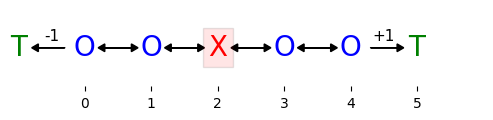

,true_values,1-step,2-step,3-step,4-step
0,-66.67%,-59.72%,-35.21%,-57.07%,-81.39%
1,-33.33%,-35.63%,15.10%,-15.31%,-68.09%
2,0.00%,13.38%,30.20%,11.07%,-49.84%
3,33.33%,51.18%,66.72%,40.46%,-23.58%
4,66.67%,70.12%,84.59%,88.16%,39.54%


true_values    0.000000
1-step         0.237260
2-step         0.753900
3-step         0.324427
4-step         0.887910
Name: RMSE, dtype: float64

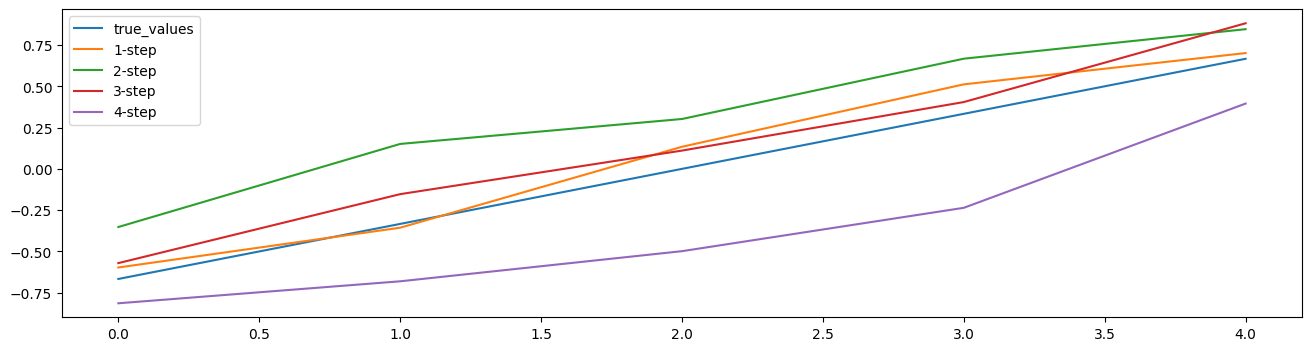

In [7]:
rewards = {
    (0, num_non_terminal_states): -1,
    (num_non_terminal_states - 1, num_non_terminal_states): 1
}

# Define a random policy for testing
def random_policy(state):
    return int(np.random.choice([0, 1]))

env = make('RL/RandomWalk-v0', num_non_terminal_states=num_non_terminal_states, start_state=start_state, rewards=rewards)
env.reset()
env.render()

value_functions = { 'true_values': np.array([i / 6 - ((6 - i) / 6) for i in range(1, 6) ]) }

for n in range(1, num_non_terminal_states):    
    value_function = standard_n_step_td(random_policy, env, n, alpha, gamma, num_episodes)
    value_functions[f"{n}-step"] = value_function

df = pd.DataFrame(value_functions)
rmse = pd.Series(
    data={
        k : sum((v - value_functions['true_values'])**2)**.5
        for k, v in value_functions.items()
    },
    name='RMSE'
)
    
display(df.style.format('{:,.2%}'.format))
display(rmse)
    
df.plot(figsize=(16,4));

- The n-step return uses the value function $V_{t+n+1}$ to correct for the missing rewards beyond $R_{t+n}$. 
- important property: expectation of n-step returns is guaranteed to be a better estimate of $v_\pi$ than $V_{t+n-1}$ (worst-state sense), i.e. for all $n \geq 1$:

$$
\max_s | \mathbb{E}_\pi[ G_{t:t+n} | S_t = s] - v_\pi(s) |  
\leq
\gamma^n \max_s | V_{t+n-1}(s) - v_\pi(s) |
,\qquad (7.3)
$$
called **error reduction property of n-step returns**. 

- $\Rightarrow$ one can show formally that all n-step TD methods converge to the correct predictions under appropriate technical conditions

### Example 7.1:
- 5-state random walk task described in Example 6.2 (page 125)

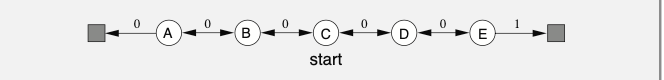

- Suppose the first episode progressed directly from the center state, C, to the right, through D and E, and then terminated on the right with a return of 1.
- Recall that the estimated values of all the states started at an intermediate value, $V(s) = 0.5$.
- Result of this experience:
    - a one-step method would change only the estimate for the last state, $V(E)$, (incremented toward 1)
    - A two-step method, $V(D)$ and $V(E)$ incremented toward 1.
    - A n-step method, with n > 2: increment values of all three visited states toward 1, all by the same amount.

- Figure 7.2: empirical test for a larger random walk process, with
    - 19 states instead of 5 (and with a - 1 outcome on the left, all values initialized to 0)
    - Results are shown for n-step TD methods with a range of values for n and $\alpha$.
    - metric: RSME averaged over the first 10 episodes and 100 repetitions of the whole experiment

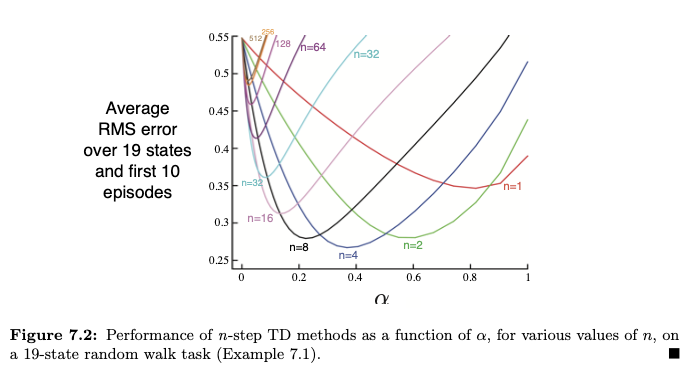


### Exercise 7.3 
- Why do you think a larger random walk task (19 states instead of 5) was used in the examples of this chapter? 
- Would a smaller walk have shifted the advantage to a different value of $n$? 
- How about the change in left-side outcome from $0$ to $-1$ made in the larger walk? 
- Do you think that made any difference in the best value of n?

#### Answer

- Why larger walk:
    - 5-states not complex enough to illustrate effects of different n's
- what if walk smaller:
    - smaller walk should converge more rapidtly (rewards signals are more immediate and lesser noisy); not benefit of large n's
- left reward = -1:
    - introduces a penalty & biasing the algorithm towards moving right
    - choice of n might be more sensitive
- Effects on n:
    - larger n's might be favourable since they can capture the positive and negative outcomes better

## 7.2. n-step Sarsa

- main idea: simply switch states for actions (state–action pairs) and then use an "$\varepsilon$-greedy policy.
- We redefine n-step returns (update targets) in terms of estimated action values:

$$
G_{t:t+n} \doteq R_{t+1} + \gamma R_{t+2} + \cdots +\gamma^{n-1} R_{t+n} +\gamma^{n}Q_{t+n-1}(S_{t+n}, A_{t+n}), \,n \geq 1, 0 \leq t < T \leq n, \qquad(7.4) 
$$
with $G_{t:t+n} \doteq G_t$ if $t + n \geq T$ . 

- **n-step Sarsa**. The natural algorithm is then 
$$ 
Q_{t+n}(S_t, A_t) \doteq Q_{t+n-1}(S_t, A_t) + \alpha [G_{t:t+n} - Q_{t+n - 1}(S_t, A_t)], \, 0 \leq t < T, \qquad (7.5)
$$
while the values of all other states remain unchanged: $Q_{t+n}(s, a) = Q_{t+n-1}(s, a)$, for all s, a such that $s \not= S_t$ or $a \not= A_t$.


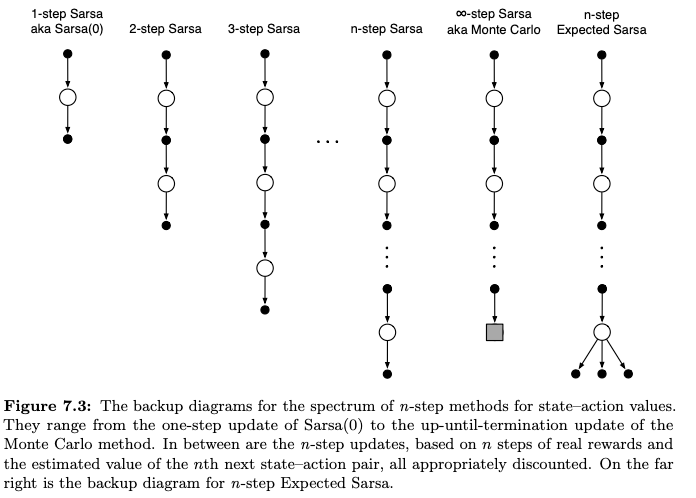

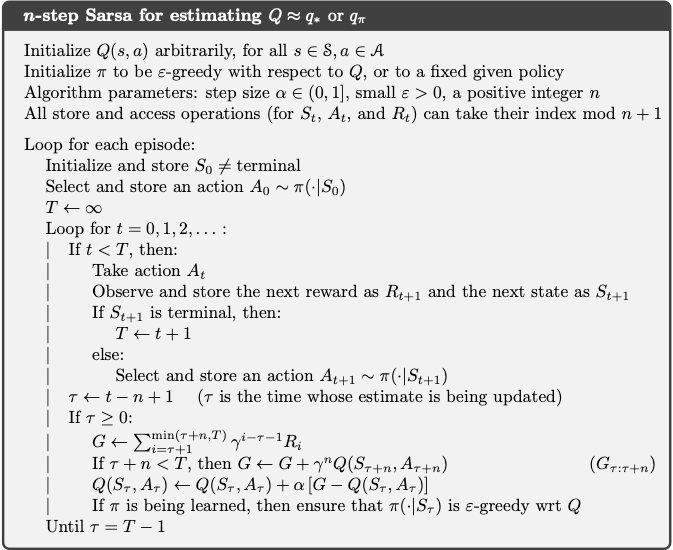

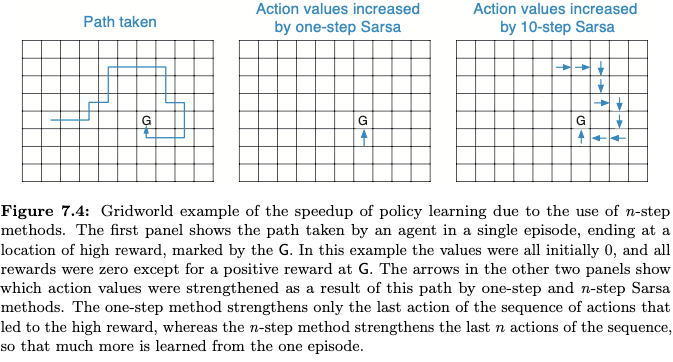

### Exercise 7.4 
Prove that the n-step return of Sarsa (7.4) can be written exactly in terms of a novel TD error, as
$$
G_{t:t+n} = Q_{t-1}(S_t, A_t) + \sum^{\min(t+n, T)-1}_{k=t} \gamma^{k-t} [R_{k+1} + \gamma Q_k (S_{k+1}, A_{k+1}) - Q_{k-1}(S_k , A_k)]. \qquad (7.6)
$$

#### Proof

Consider the n-step return of Sarsa (7.4):

\begin{align}
G_{t:t+n} \doteq& R_{t+1} + \gamma R_{t+2} + \cdots + \gamma^{n-1} R_{t+n} + \gamma^n Q_{t + n - 1}(S_{t+n}, A_{t+n}) \\ 
\end{align}

Introduce Q-value terms:
\begin{align}
G_{t:t+n} =& R_{t+1} + \gamma R_{t+2} + \cdots + \gamma^{n-1} R_{t+n} + \gamma^n Q_{t + n - 1}(S_{t+n}, A_{t+n}) \\ 
&+ (\gamma^{0} Q_{t-1} (S_{t}, A_{t}) - \gamma^{0} Q_{t-1} (S_{t}, A_{t}))  \\
&+ (\gamma^{1} Q_t (S_{t+1}, A_{t+1}) - \gamma^{1} Q_t (S_{t+1}, A_{t+1}))  \\
&+ (\gamma^{2} Q_{t+1} (S_{t+2}, A_{t+2}) - \gamma^{2} Q_{t+1} (S_{t+2}, A_{t+2}))  \\
&+ \dots \\
&+ (\gamma^{n} Q_{t+n-1} (S_{t+n}, A_{t+n}) - \gamma^{n} Q_{t+n-1} (S_{t+n}, A_{t+n}))\\
\end{align}

Re-Arrange terms:
\begin{align}
G_{t:t+n} =& \gamma^{0} Q_{t-1}(S_t, A_t) \\
      &+  \gamma^{0} R_{t+1} + \gamma^1 Q_t (S_{t+1}, A_{t+1}) - \gamma^{0}  Q_{t-1}(S_t , A_t) \\
      &+  \gamma^{1} R_{t+2} + \gamma^2 Q_{t+1} (S_{t+2}, A_{t+2}) - \gamma^{1} Q_{t}(S_{t+1} , A_{t+1}) \\
      & \cdots \\
      &+  \gamma^{n-1} R_{t+n} + \gamma^n Q_{t+n-1} (S_{t+n}, A_{t+n}) - \gamma^{n-1} Q_{t+n-2}(S_{t+n-1} , A_{t+n-1}) \\  
\end{align}

Bracket $\gamma$ out:
\begin{align}
G_{t:t+n} =& Q_{t-1}(S_t, A_t) \\
      &+  \gamma^{0} [R_{t+1} + \gamma Q_t (S_{t+1}, A_{t+1}) - Q_{t-1}(S_t , A_t)] \\
      &+  \gamma^{1} [R_{t+2} + \gamma Q_{t+1} (S_{t+2}, A_{t+2}) - Q_{t}(S_{t+1} , A_{t+1})] \\
      & \cdots \\
      &+  \gamma^{n-1} [R_{t+n} + \gamma Q_{t+n-1} (S_{t+n}, A_{t+n}) - Q_{t+n-2}(S_{t+n-1} , A_{t+n-1})] \\  
    &= Q_{t-1}(S_t, A_t) + \sum^{\min(t+n, T)-1}_{k=t} \gamma^{k-t} [R_{k+1} + \gamma Q_k (S_{k+1}, A_{k+1}) - Q_{k-1}(S_k , A_k)]  \\ 
    && \square
\end{align}

### n-step Expected-Sarsa

- backup diagram shown on far right in Figure 7.3. 
- It consists of a linear string of sample actions and states, just as in n-step Sarsa, except that its last element is a branch over all action possibilities weighted, as always, by their probability under $\pi$. 
- algorithm described by same equation as n-step Sarsa (above) except with the n-step return redefined as
$$
G_{t:t+n} \doteq R_{t+1} + \cdots + \gamma^{n-1} R_{t+n} + \gamma ^ n \bar V_{t+n-1}(S_{t+n}),\, t + n < T, \qquad(7.7)
$$
(with $G_{t:t+n} \doteq G_t$ for $t + n \geq T$ ) where $\bar V_t(s)$ is the expected approximate value of state s,
- using the estimated action values at time t, under the target policy:
$$
\bar V_t(s) \doteq \sum_a \pi(a|s)Q_t(s, a), \forall s \in S \qquad (7.8)
$$

- If s is terminal, then its expected approximate value is defined to be 0.

## 7.3 n-step Off-policy Learning

- Recall that off-policy learning is learning the value function for one policy, $\pi$, while following another policy, $b$. 
- Often, $\pi$ is the greedy policy for the current action-value-function estimate, and $b$ is a more exploratory policy, perhaps $\varepsilon$-greedy. 
- In order to use the data from b we must take into account the difference between the two policies, using their relative probability of taking the actions that were taken (see Section 5.5). 
- In n-step methods, returns are constructed over n steps, so we are interested in the relative probability of just those n actions. 
- For example, to make a simple off-policy version of n-step TD, the update for time t (actually made at time $t + n$) can simply be weighted by $\rho_{t:t+n-1}$:
- 
$$
V_{t+n}(S_t) \doteq V_{t+n-1}(S_t) + \alpha \rho_{t:t+n-1} [G_{t:t+n}  - V_{t+n-1}(S_t)],\, 0 \leq t < T, \qquad(7.9)
$$

where $\rho_{t:t+n-1}$, called the _importance sampling ratio_, is the relative probability under the two policies of taking the n actions from $A_t$ to $A_{t+n-1}$ (cf. Eq. 5.3):
$$
\rho_{t:h} \doteq \prod^{\min(h,T-1)}_{k=t} \frac{\pi(A_k | S_k )}{b(A_k | S_k )}. \qquad (7.10)
$$

- Motivation:
    - underweight actions that would unlikely be chosen by $\pi$
    - overweight actions that would be taken by $\pi$ with a higher prob. then by $b$ to learn more about those
    - Note: if $\pi \equiv b$, then $\rho \equiv 1$

- Similarly, n-step Sarsa update can be replaced by a simple off-policy form:
$$
Q_{t+n}(S_t, A_t) \doteq Q_{t+n-1}(S_t, A_t) + \alpha \rho_{t+1:t+n} [G_{t:t+n} - Q_{t+n-1}(S_t, A_t)],\qquad (7.11)
$$
for $0 \leq t < T$.

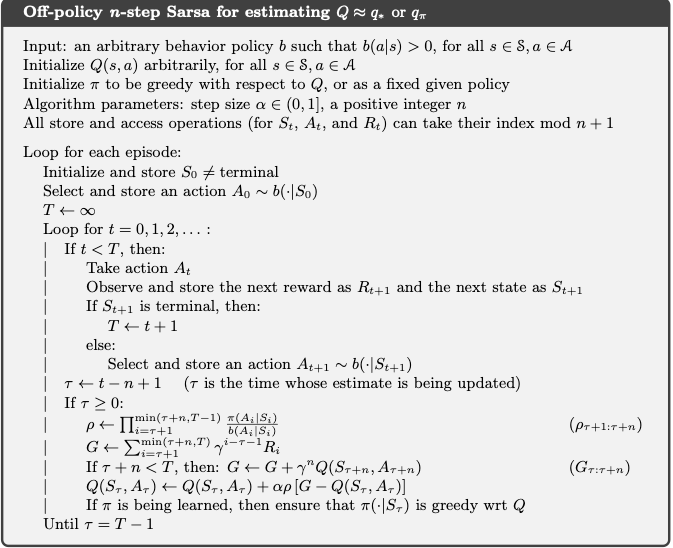

## 7.4 *Per-decision Methods with Control Variates

- more sophisticated approach would use per-decision importance sampling ideas such as were introduced in Section 5.9.
- n-step return (7.1), can be written recursively:
$$
G_{t:h} = R_{t+1} + \gamma G_{t+1:h},\quad t < h < T \qquad (7.12)
$$
where $G_{h:h} \doteq V_{h-1}(S_h)$


- **importance sampling ratio**.
    - considering effect of following a behavior policy b that is not the same
as the target policy $\pi$, all of the resulting experience must be weighted by the importance sampling ratio
    - Suppose the action at time t would never be selected by $\pi$, so that $\rho_t$ is zero.
    - Then a simple weighting of righthand side would result in the n-step return being zero, which could result in high variance when it was used as a target.

- more sophisticated approach: use an alternate, off-policy definition of the n-step return ending at horizon h, as
$$
G_{t:h} \doteq \rho_t (R_{t+1} + \gamma G_{t+1:h}) + (1 - \rho_t) V_{h-1}(S_t), \quad t < h < T, \qquad(7.13)
$$

where again $G_{h:h} \doteq V_{h-1}(S_h)$. 

- In this approach, if $\rho_t$ is zero, then instead of the target being zero and causing the estimate to shrink, the target is the same as the estimate and causes no change.
- The importance sampling ratio being zero means we should ignore the sample, so leaving the estimate unchanged seems appropriate.
- The second, additional term in (7.13) is called a control variate
- Notice that the control variate does not change the expected update; the importance sampling ratio has expected value one (Section 5.9) and is uncorrelated with the estimate, so the expected value of the control variate is zero.
- Also note that the off-policy definition (7.13) is a strict generalization of the earlier on-policy definition of the n-step return (7.1), as the two are identical in the on-policy case, in which $\rho_t$ is always 1.
- For a conventional n-step method, the learning rule to use in conjunction with (7.13) is the n-step TD update (7.2), which has no explicit importance sampling ratios other than those embedded in the return.

### Exercise 7.5 
Write the pseudocode for the off-policy state-value prediction algorithm described above.

For action values, the off-policy definition of the n-step return is a little different because the first action does not play a role in the importance sampling. 
That first action is the one being learned; it does not matter if it was unlikely or even impossible under the target policy—it has been taken and now full unit weight must be given to the reward and state that follows it. Importance sampling will apply only to the actions that follow it.

First note that for action values the n-step on-policy return ending at horizon h, expectation form (7.7), can be written recursively just as in (7.12), except that for action values the recursion ends with $G_{h:h} \doteq V_{h-1}(S_h)$ as in (7.8). 
An off-policy form with control variates is

\begin{align}
G_{t:h} & \doteq R_{t+1} + \gamma \left( \rho_{t+1} G_{t+1:h} + \bar V_{h-1}(S_{t+1}) - \rho_{t+1} Q_{h-1}(S_{t+1}, A_{t+1}) \right), \\
&= R_{t+1} + \gamma \rho_{t+1} \left(G_{t+1:h} - Q_{h - 1}(S_{t+1}, A_{t+1})\right)
+ \gamma \bar V_{h - 1}(S_{t+1}), \quad t < h  \leq T. \quad (7.14)
\end{align}

If $h < T$, then the recursion ends with $G_{h:h} \doteq Q_{h-1}(S_h, A_h)$, whereas, if $h \geq T$, the recursion ends with and $G_{T-1:h} \doteq R_T$. 
The resultant prediction algorithm (after combining with (7.5)) is analogous to Expected Sarsa.

### Exercise 7.6 
Prove that the control variate in the above equations does not change the expected value of the return.

### *Exercise 7.7 
Write the pseudocode for the o↵-policy action-value prediction algorithm described immediately above. Pay particular attention to the termination conditions for the recursion upon hitting the horizon or the end of episode.

### Exercise 7.8 
Show that the general (off-policy) version of the n-step return (7.13) can still be written exactly and compactly as the sum of state-based TD errors (6.5) if the approximate state value function does not change.

### Exercise 7.9
Repeat the above exercise for the action version of the off-policy n-step return (7.14) and the Expected Sarsa TD error (the quantity in brackets in Equation 6.9).

### Exercise 7.10 (programming) 

Devise a small off-policy prediction problem and use it to show that the off-policy learning algorithm using (7.13) and (7.2) is more data effcient than the simpler algorithm using (7.1) and (7.9).
The importance sampling that we have used in this section, the previous section, and in Chapter 5, enables sound off-policy learning, but also results in high variance updates, forcing the use of a small step-size parameter and thereby causing learning to be slow. 
It is probably inevitable that off-policy training is slower than on-policy training—after all, the data is less relevant to what is being learned. 
However, it is probably also true that these methods can be improved on. 
The control variates are one way of reducing the variance. 
Another is to rapidly adapt the step sizes to the observed variance, as in the Autostep method (Mahmood, Sutton, Degris and Pilarski, 2012). 
Yet another promising approach is the invariant updates of Karampatziakis and Langford (2010) as extended to TD by Tian (in preparation). 
The usage technique of Mahmood (2017; Mahmood and Sutton, 2015) may also be part of the solution. 
In the next section we consider an off-policy learning method that does not use importance sampling.

## 7.5 Off-policy Learning Without Importance Sampling: The n-step Tree Backup Algorithm


- off-policy learning without importance sampling (like Q-learning and Expected Sarsa for one-step, see Chapter 6

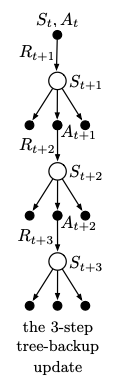

**Tree-backup algorithm**. 
idea:
- Down the "central spine" and labeled in the diagram are three sample states and rewards, and two sample actions.
- These are the random variables representing the events occurring after the initial state–action pair $S_t$, $A_t$.
- Hanging off to the sides of each state are the actions that were _not_ selected.
- (For the last state, all the actions are considered to have not (yet) been selected.)
- Because we have no sample data for the unselected actions, we bootstrap and use the estimates of their values in forming the target for the update.

Tree-backup update, is an update from the entire tree of estimated action values:
    - update the estimated value of the node at the top of the diagram toward a target combining the rewards along the way (appropriately discounted)
    - estimated values of the nodes at the bottom.
    - estimated values of the dangling action nodes hanging off the sides, at all levels.

- Each leaf node contributes to the target with a weight proportional to its probability of occurring under the target policy $\pi$.
- each arrow to an action node in the diagram is weighted by the action’s probability of being selected under the target policy:
    - each first-level action a contributes with a weight of $\pi(a|S_{t+1})$ (except action actually taken, $A_{t+1}$, does not contribute at all) (probability, $\pi(A_{t+1} | S_{t+1})$)
    - each non-selected second-level action $a'$ contributes with weight $\pi(A_{t+1}|S_{t+1}) \pi(a'|St+2)$.
    - Each third-level action contributes with weight $\pi(A_{t+1}|S_{t+1}) \pi(A_{t+2}|S_{t+2}) \pi(a''|S_{t+3})$, and so on.

- one-step return (target) is the same as that of Expected Sarsa,
$$
G_{t:t+1} \doteq R_{t+1} + \gamma \sum_a \pi(a|S_{t+1})Q_t(S_{t+1}, a), \qquad(7.15)
$$

for $t < T - 1$, and the two-step tree-backup return is
\begin{align}
G_{t:t+2} &\doteq 
R_{t+1} 
+ \gamma \sum_{a \not= A_{t+1}} \pi(a|S_{t+1}) Q_{t+1}(S_{t+1}, a) 
+ \gamma \pi(A_{t+1}|S_{t+1}) \left( R_{t+2} + \gamma \sum_a \pi(a|S_{t+2})Q_{t+1}(S_{t+2}, a) \right) \\
&= R_{t+1} + \gamma \sum_{a \not= A_{t+1}} \pi(a|S_{t+1})Q_{t+1}(S_{t+1}, a) + \gamma \pi(A_{t+1}|S_{t+1})G_{t+1:t+2}
\end{align}

for $t < T - 2$.

- The latter form suggests the general recursive definition of the tree-backup
n-step return:
$$
G_{t:t+n} \doteq R_{t+1} + \gamma \sum_{a \not= A_{t+1}} \pi(a|S_{t+1})Q_{t+n-1}(S_{t+1}, a) + \gamma \pi(A_{t+1}|S_{t+1})G_{t+1:t+n}, \qquad (7.16)
$$
for $t < T-1,\, n \geq 2$, with the $n = 1$ case handled by (7.15) except for $G_{T-1:t+n} \doteq R_T$.

- This target is then used with the usual action-value update rule from n-step Sarsa:
$$
Q_{t+n}(S_t, A_t) \doteq Q_{t+n-1}(S_t, A_t) + \alpha [ G_{t:t+n} - Q_{t+n-1}(S_t, A_t) ],
$$

for $0 \leq t < T$ , while the values of all other state–action pairs remain unchanged:
$Q_{t+n}(s, a) = Q_{t+n-1}(s, a)$, for all s, a such that $s \not= S_t$ or $a \not= A_t$. 

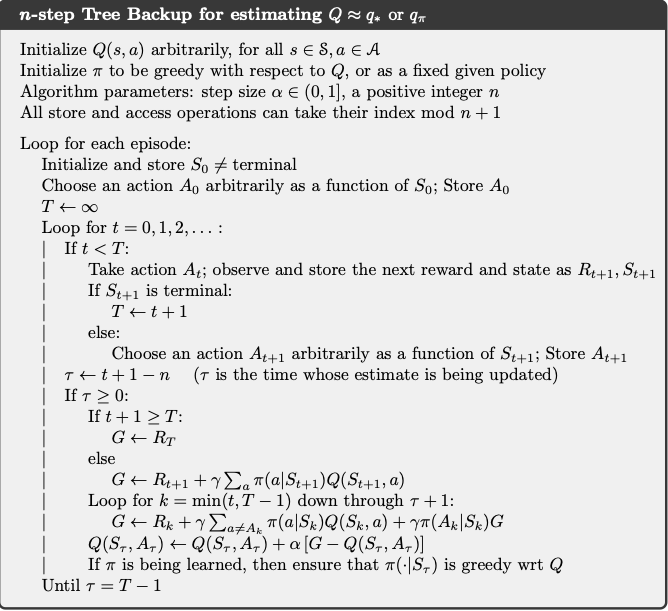

### Exercise 7.11 
Show that if the approximate action values are unchanging, then the tree-backup return (7.16) can be written as a sum of expectation-based TD errors:

$$
G_{t:t+n} = Q(S_t, A_t) +
\sum^{\min(t+n-1,T-1)}_{k=t} \delta_k \prod_{i=t+1}^k \gamma '\pi (A_i|S_i),
$$

where $\delta_t \doteq R_{t+1} + \gamma \bar V_t(S_{t+1}) - Q(S_t, A_t)$ and $\bar{V}_t$ is given by (7.8).

#### Proof

Remember expected approximate value of state $s$ (7.8) expected approximate value of state s (discarding time steps since action values are unchanging):
$$
\bar V(s) \doteq \sum_a \pi(a|s)Q(s, a) 
$$

Thus, we can rewrite the recursive tree-backup returns (7.16) as follows:
\begin{align}
G_{t:t+n} \doteq& R_{t+1} 
+ \gamma \sum_{a \not= A_{t+1}} \pi(a|S_{t+1})Q(S_{t+1}, a)
+ \gamma \pi(A_{t+1}|S_{t+1})G_{t+1:t+n}
\end{align}

Extend series by $A_{t+1}$:
\begin{align}
=& R_{t+1} 
+ \gamma \sum_{a} \pi(a|S_{t+1})Q(S_{t+1}, a) \\
&- \gamma \pi(A_{t+1}|S_{t+1})Q(S_{t+1}, A_{t+1})
+ \gamma \pi(A_{t+1}|S_{t+1})G_{t+1:t+n}
\end{align}

Use defintion of V and use brackets for latter terms:
\begin{align}
=& R_{t+1} 
+ \gamma \bar V(S_{t+1}) 
+ \gamma \pi \left( A_{t+1}|S_{t+1}) (-Q(S_{t+1}, A_{t+1}) + G_{t+1:t+n} \right)
\end{align}

Add auxilary Q-values and use definition of $\delta_t$:
\begin{align}
=& Q(S_t, A_t) + \delta_t 
+ \gamma \pi ( A_{t+1}|S_{t+1}) \left[ -Q(S_{t+1}, A_{t+1}) + G_{t+1:t+n} \right]
\end{align}

Use this form for the recursion:
\begin{align}
=& Q(S_t, A_t) + \delta_t \\
&+ \gamma \pi ( A_{t+1}|S_{t+1}) [\cancel{- Q(S_{t+1}, A_{t+1}) + Q(S_{t+1}, A_{t+1}) } \\
  &\quad+ \delta_{t+1}
    + \gamma \pi ( A_{t+2}|S_{t+2}) [ -Q(S_{t+2}, A_{t+2}) + G_{t+2:t+n} ]
] \\
=& Q(S_t, A_t) + \delta_t \\
&+ \gamma \pi ( A_{t+1}|S_{t+1})
    \left[ 
        \delta_{t+1}
        + \gamma \pi ( A_{t+2}|S_{t+2}) 
            [ -Q(S_{t+2}, A_{t+2}) + G_{t+2:t+n} ]
    \right]
  \\
=& \dots  
\end{align}

\begin{align}
=&\dots\\
=& Q(S_t, A_t) \\
&+ \delta_t + \gamma \pi ( A_{t+1}|S_{t+1}) [ \\
    &\quad\delta_{t+1} + \gamma \pi ( A_{t+2}|S_{t+2}) [ \\
    &\quad\quad \delta_{t+2} + \gamma \pi ( A_{t+3}|S_{t+3}) [ \\
            &\quad\quad\quad  \dots \\
            &\quad\quad\quad  \delta_{t+n-1} 
            + \gamma \pi ( A_{t+n} | S_{t+n}) 
            \underbrace{[ -Q(S_{t+n}, A_{t+n}) + \underbrace{G_{t+n:t+n}}_{Q(S_{t+n}, A_{t+n})} ]}_0  \\
    &\quad \dots ] ] ] \\
=& Q(S_t, A_t) + \sum^{\min(t+n-1,T-1)}_{k=t} \delta_k \prod_{i=t+1}^k \gamma \pi (A_i|S_i)    \\
&&\square
\end{align}

## 7.6 *A Unifying Algorithm: n-step $Q(\sigma)$

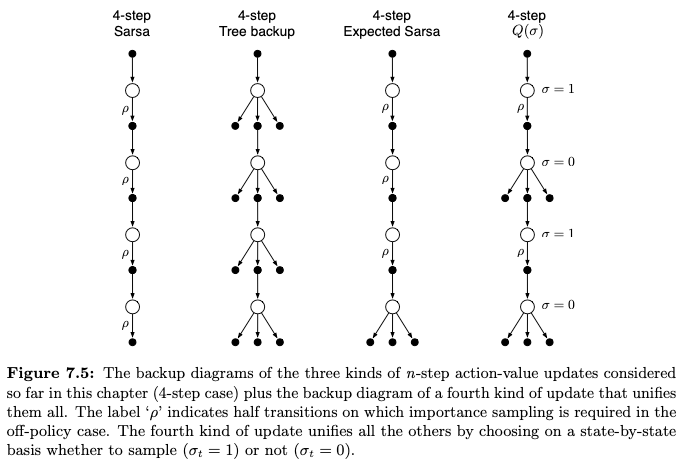

**n-step $Q(\sigma)$**. 
- Let $\sigma_t \in [0, 1]$ denote the degree of sampling on step t, with
    - $\sigma = 1$ denoting full sampling and
    - $\sigma =  0$ denoting a pure expectation with no sampling. 

The random variable $\sigma_t$ might be set as a function of the state, action, or state–action pair at time t. 


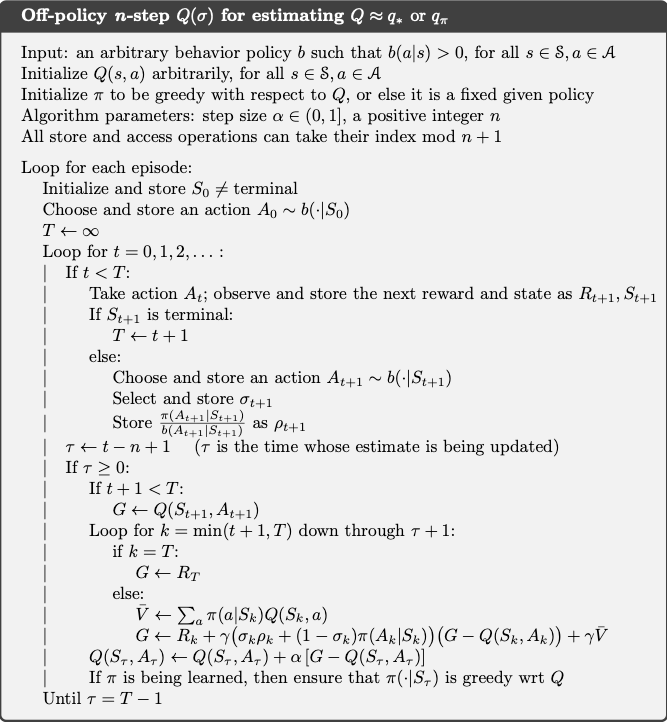

## 7.7 Summary

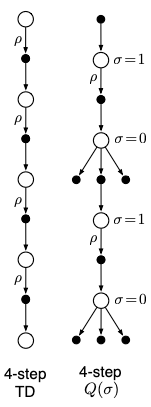

- **Intermediate TD Methods**: The chapter introduces temporal-difference (TD) learning methods that balance between one-step TD methods and Monte Carlo methods.
- **Benefits of Intermediate Bootstrapping**: These methods often outperform the extremes by using an intermediate amount of bootstrapping.
- **Focus on n-step Methods**: Emphasizes n-step methods, which consider the next n rewards, states, and actions in their updates.
- **Backup Diagrams**: Two 4-step backup diagrams above summarize key methods, including n-step TD with importance sampling and n-step $Q(\sigma)$.
- **Delays and Complexity**: n-step methods involve a delay of n time steps for updates and require more computation and memory than one-step methods.
- **Future Efficiency**: Chapter 12 will discuss implementing multi-step TD methods with minimal complexity using eligibility traces.
- **Conceptual Clarity**: Despite their complexity, n-step methods provide clear conceptual insights.
- **Off-policy Learning Approaches**:
    - **Importance Sampling**: Simple but high variance; requires further development for efficiency.
    - **Tree-backup Updates**: Extends Q-learning to multi-step with stochastic target policies, avoiding importance sampling but limited by policy differences.